<table style="width:100%; background-color:#FFFFFF" align="left">
 <tr>
   <td style="text-align:left; background-color:#FFFFFF">
       <p><strong>Prof. Dr. Stefan Decker</strong><br>
        W. Fahl, M. Slupczynski </p>
        <p><strong>04.2023</strong></p>
     </td>
   <td style="text-align:right; background-color:#FFFFFF">
     <div>
       <img src="https://git.rwth-aachen.de/i5/teaching/dbis-raw/-/raw/main/dbis-logo.png" width="500"/>
     </div>
    </td>
 </tr>
</table>
<div class="clearfix"></div>
<center>
    <h1> Datenbanken und Informationssysteme <br />
        <small>(Sommersemester 2023)</small> </h1>    
    <h1> Vorlesung - Graphdatenbanken - Gremlin </h1>
</center>

# Vorlesung als Notebook

Dieses Notebook dient als interaktive Version der Folien zum Kapitel [Graphdatenbanken - Gremlin](http://dbis-vl.wikidata.dbis.rwth-aachen.de/index.php/Keyword/graph_database).

**Lernziel:** Die Studierenden sollen die Grundlagenkonzepte zu und den Nutzen von Graphdatenbanken kennenlernen. Dazu gehören u.a. die Unterschiede zwischen diesen und relationalen Datenbanken. Es wird zur Veranschaulichung die Graphtraversierungssprache und -anfragesprache Gremlin benutzt. Die Studierenden sollen in der Lage sein, einfache Gremlin-Traversals zu verstehen und zu bewerten sowie eigene Traversals zu verfassen. Des weiteren sollen die Studierenden die Unterschiede zwischen Online Analytical Processing (OLAP) und Online Transaction Processing (OLTP) verstehen.

Es werden Grundkenntnisse zu relationalen Datenbanken vorausgesetzt.

**Ablauf:** Der Ablauf wird folgende Schritte umfassen:
* Grundlagen zu Graphdatenbanken
* Gremlin Traversal-Steps
    * Erstellen eines einfachen Graphen mit Gremlin
    * Abfragen in Gremlin

##### Weiterführende Materialien:
* [The Gremlin Graph Traversal Machine and Language](https://arxiv.org/abs/1508.03843v1)
* [Practical Gremlin Guide](https://kelvinlawrence.net/book/Gremlin-Graph-Guide.html)
* [Stackoverflow - gremlinpython](https://stackoverflow.com/questions/tagged/gremlinpython)

<h2>Jupyter Notebook Vorbereitung</h2>
Zunächst sind einige technische Vorbereitungen erforderlich.

<div class="alert alert-info">
	<p>
		Die folgenden Zellen müssen am Anfang der Bearbeitung ausgeführt werden.<br />
		Die erste Zelle (<code># ABHÄNGIGKEITEN INSTALLIEREN</code>) installiert alle für diese Übung benötigten Abhängigkeiten. <br />
		Die zweite Zelle (<code># SERVER STARTEN</code>) startet den Server im Hintergrund. <br />
		Die dritte Zelle (<code># MIT SERVER VERBINDEN</code>) verbindet das Notebook mit dem Server. <br />
		Die vierte Zelle (<code># BEISPIELGRAPHEN</code>) testet, ob Beispielgraphen geladen werden können. <br />
	</p>
	<p>
	Nach der Ausführung der vierten Code-Zelle sollte die Meldung <b>"Server OK! Es kann losgehen!"</b> angezeigt werden. 
	</p>
</div>

In [1]:
# ABHÄNGIGKEITEN INSTALLIEREN
# https://pypi.org/project/gremlinpython/
# https://pypi.org/project/gremlin-python-tutorial/
from IPython.display import display, Markdown, Math, HTML, Code
display(Markdown("### ⌛ Abhängigkeiten werden installiert. Dies kann etwas dauern."))
%pip install -q --upgrade gremlinpython gremlin-python-tutorial
def success(msg):
    display(HTML(f"<div class='alert alert-success'><h1>{msg}</h1></div>"))
    
success("Abhängigkeiten erfolgreich installiert.")

### ⌛ Abhängigkeiten werden installiert. Dies kann etwas dauern.

Note: you may need to restart the kernel to use updated packages.


In [2]:
# GREMLIN SERVER STARTEN
import subprocess
import time
gremlin_server_path = '/opt/gremlin-server'
gremlin_command = f'{gremlin_server_path}/bin/gremlin-server.sh {gremlin_server_path}/conf/gremlin-server.yaml'
gremlin_server_process = subprocess.Popen(gremlin_command.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
time.sleep(3)

success("Gremlin Server gestartet.")

In [3]:
# MIT SERVER VERBINDEN
# see https://github.com/WolfgangFahl/gremlin-python-tutorial/blob/master/test_001.py
from gremlin.remote import RemoteTraversal, Server

# initialize a remote traversal
server=Server(host="127.0.0.1")
rt=RemoteTraversal(server)
g = rt.g()
success("Verbindung zu Gremlin Server/Graphtraversal g verfügbar.")

In [4]:
# BEISPIELGRAPHEN laden
from gremlin.examples import Volume,Examples
example_path="/home/jovyan/dbis-23/assets/gremlin/examples"
volume=Volume(local_path=example_path,remote_path=example_path)
examples=Examples(volume)
names=','.join(list(examples.examples_by_name.keys()))

import os
os.makedirs(example_path, exist_ok=True)

success(f"Beispielgraphen: {names} erfolgreich vorbereitet")

---
# Grundlagen zu Graphdatenbanken + Einführung in Beispiel

## Was ist eine Graphdatenbank? - Motivation

Bisher kennen wir relationale Datenbanken. Diese bestehen aus einer Sammlung von Tabellen mit Datensätzen, die Werte zu verschiedenen Attributen enthalten. Die Verbindungen zwischen den Relationen werden dadurch realisiert, dass der/die Schlüssel einer Tabelle in anderen Tabellen wiederverwendet werden. Die Regeln für eine relationale Datenbank wird durch ihr Relationsschema eindeutig spezifiziert. Will man dieses ändern, sind ggf. auch Änderungen an den Datensätzen vornehmen.

Graphdatenbanken sind dagegen anders aufgebaut. Alle Daten werden in einem einzigen Graphen zusammengefasst. Dadurch lassen sich stark vernetzte Datenbankstrukturen leichter und intuitiver darstellen. Abfragen werden mit Hilfe von Traversals (dt.: Traversieurung) formuliert, mit denen man den Graphen Schritt für Schritt durchlaufen kann.

## Elemente einer Graphdatenbank

$G = \{V, E\}$

Zu einem Graphen gehören in einer Graphdatenbank wie in der Graphentheorie üblich für Graphen $G$ Knoten (Vertices, $V$) und Kanten (Edges, $E$), die die Knoten verbinden.

## Gremlin

Graphen in Gremlin sind sogenannte Property-Graphen. \
Ein Element einer Graphdatenbank (Knoten, Kante) hat in Gremlin die folgenden Eigenschaften:
* Eine eindeutige **ID**, die beim Erstellen des Elements zugewiesen wird. Insbesondere gibt es keine Überschneidung der IDs zwischen Kanten und Knoten.
* Ein **Label**. Dies würde bei relationalen Datenbanken etwa dem Relationsnamen entsprechen.
* Eine Sammlung von **Records** mit jeweils einer Kombination aus Key und Value. Sie speichern Eigenschaften zum Element.

Außerdem sind Kanten in Gremlin gerichtet, sie haben also einen **Startknoten** und einen **Zielknoten**.

### Sprachelemente

In relationalen Datenbanken hatten wir zwischen DDL, DML, DQL, DCL und TCL unterschieden, d.h. für die Definition, die Manipulation, die Abfrage, die Zugriffsrechtsvergabe und die Transaktionssteuerung gab es jeweils spezielle Sprachelemente. In Gremlin ist das Traversal das Kern-Sprachelement für praktisch alle diese Themen.

## Beispiel-Graphdatenbank: Modern-Graph

Der "Modern"-Graph ist der offizielle Beispielgraph von [Apache Gremlin / Tinkerpop](https://tinkerpop.apache.org/docs/current/tutorials/getting-started/).

![](https://tinkerpop.apache.org/docs/current/images/tinkerpop-modern.png "Modern")

* **Beispiel:** Knoten mit ID ```1```, Label ```person```, Records für ```name``` und ```age``` und drei ausgehenden Kanten.

In [5]:
# PYTHON GREMLIN/Jupyter Infrastructure
# Asyncio workaround
import nest_asyncio
nest_asyncio.apply()
# load statics
from gremlin_python import statics
statics.load_statics(globals())
# display of graph traversals
from gremlin.draw import GremlinDraw
success("Gremlin Python Infrastruktur vorbereitet")

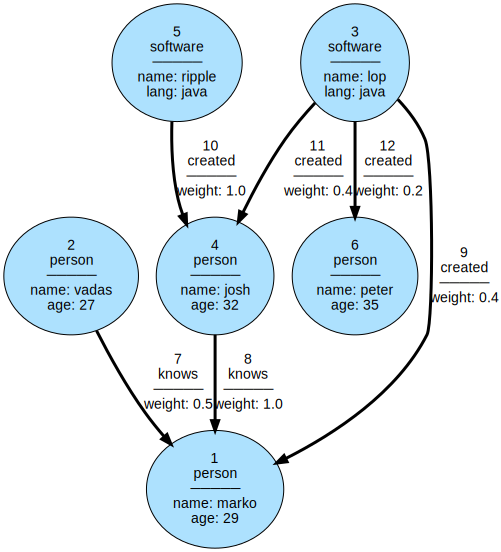

In [6]:
# show modern graph in Tutorial style
examples.load_by_name(g, "tinkerpop-modern")
GremlinDraw.show(g)

Wir benutzen zur Darstellung von Graphen die Library graphviz für Python. Dazu stellen wir eine Klasse ```GremlinDraw``` zur Verfügung, die die Visualisierung ermöglicht. Die Darstellung ist leicht abweichend:

## Funktionen in Gremlin

### Gremlin Grundprinzipien

Der Initiator des Gremlin-Projekts Marko Rodriguez erläutert in seinem [Paper](https://arxiv.org/pdf/1508.03843v1.pdf) die folgenden Grundprinzipien:
* Graph Traversal Machine
* Graph Traversal Language
* Traversal Strategies
* Distributed Graph Traversals
* Minimal Gremlin Traversal Machines

Zunächst beschreiben wir hier die Graph Traversal Machine und Graph Traversals.

### Graph Traversal Machine
In der Graphentheorie versteht man unter einem [Graph-Traversal](https://en.wikipedia.org/wiki/Graph_traversal) ein Verfahren, einen Graphen zu durchlaufen. Das bedeutet, dass verschiedene Elemente eines Graphen besucht werden. Ein Full Traversal besucht jeden Knoten und jede Kante genau einmal. Dafür gibt es Standardalgorithmen wie Tiefensuche (Depth-first search) oder Breitensuche (Breadth-first search). Es kann aber auch nur eine Teilmenge von diesen durchlaufen werden.

### Graph Traversal Language

Die Operationen innerhalb einer Traversierung sind in Gremlin mit einem [Fluid Interface](https://de.wikipedia.org/wiki/Fluent_Interface) aufgebaut, das auf sogenannten Steps (dt.: Schritten) basiert. Die Gremlin Graph Traversal Language definiert ca. 30 solcher Steps. Auf einer Graph Traversal Source (also einem Graphen, per Konvention Variable ```g```) werden Traversals gestartet. Bei jeder aufgerufenen Funktion werden Regeln für das Traversal formuliert und es wird anschließend ein modifiziertes Traversal zurückgegeben, auf der dann die nächste Funktion aufgerufen wird. So kann man einen Graphen einfach und intuitiv durchlaufen. Die letzte Funktion in der Funktionskette ist immer genau ein Terminal Step (dt.: Terminierungsschritt), der die eigentliche Ausführung des Traversals startet.

* **Beispiel:** Gebe alle Knoten bzw. alle Kanten des Modern-Graphen aus.

[v[1], v[2], v[3], v[4], v[5], v[6]]


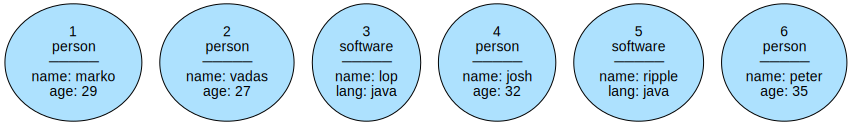

In [7]:
examples.load_by_name(g, "tinkerpop-modern")

traversal = g.V().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[e[7][1-knows->2], e[8][1-knows->4], e[9][1-created->3], e[10][4-created->5], e[11][4-created->3], e[12][6-created->3]]


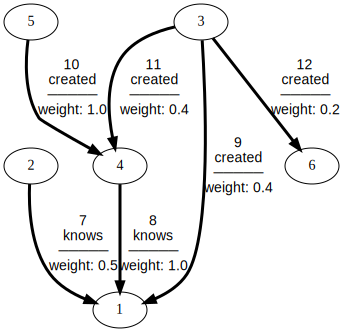

In [8]:
traversal = g.E().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

Hier sehen wir das einfachste mögliche Traversal. Auf der Graph Traversal Source ```g``` wird der Step ```V()``` angewendet, um alle Knoten des Graphen zu erhalten. Analog wird der Step ```E()``` zum Traversal über alle Kanten benutzt. Die Funktion ```toList()``` ist ein Beispiel für einen Terminal Step, der alle Ergebnisse (d.h. alle Knoten bzw. alle Kanten) in einer Liste ausgibt.

Außerdem kann man hier erkennen, dass die Knoten und Kanten standardmäßig aufsteigend nach ihrer ID besucht werden. Man kann die Reihenfolge ändern, wenn man das Traversal z.B. nur zu bestimmten Knoten bewegen möchte. Diese kann man dann als Parameterliste angeben.

[v[2], v[1]]


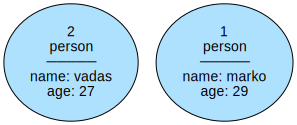

In [9]:
traversal = g.V(2,1).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

## Traversal Strategies

(Fast) jede Funktion in Gremlin (Ausnahme: Step Modulators) ist einem Traversal Step oder einem Terminal Step gleichzusetzen. Jeder Traversal Step ist einer dieser Kategorien zuzuordnen:

* side Effect Steps
* filter Steps
* flatMap Steps
* map Steps
* branch Steps

![](https://tinkerpop.apache.org/docs/3.4.1/images/step-types.png)

Die verschiedenen Kategorien werden in den folgenden Abschnitten beschrieben.

## Terminal Steps

Traversal Steps in Gremlin haben als Rückgabe in der Regel wieder ein Traversal, bzw. ein Teil des Graphen. Ein Traversal muss in Gremlin mit einem sogenannten Terminal Step beendet werden, der die eigentliche Ausführung darstellt. Dabei gibt es verschiedene Möglichkeiten, die je nach Situation angewendet werden.

### toList, toSet

Die Funktionen ```toList()``` und ```toSet()``` geben alle Ergebnisse als Liste bzw. als Menge (also ohne Duplikate) aus.

[v[1], v[2], v[2], v[2], v[2], v[3]]


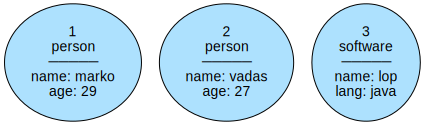

In [10]:
examples.load_by_name(g, "tinkerpop-modern")

traversal = g.V(1,2,2,2,2,3).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

{v[1], v[2], v[3]}


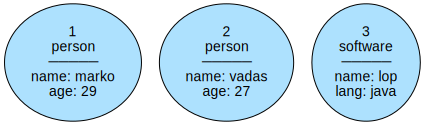

In [11]:
traversal = g.V(1,2,2,2,2,3).toSet()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

### next
```next([<Anzahl Ergebnisse>])``` gibt die nächsten n Ergebnisse des Traversals aus. Wird kein Parameter angegeben, so wird genau ein Ergebnis ausgegeben.

v[1]


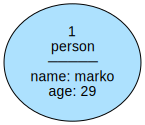

In [12]:
traversal = g.V(1,2,3).next()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[v[1], v[1], v[2]]


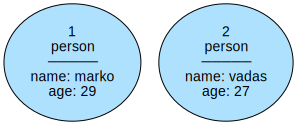

In [13]:
traversal = g.V(1,1,2,2,3,3).next(3)

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

### hasNext

Die Funktion ```hasNext()``` gibt aus, ob es ein Ergebnis gibt. Das ist nicht zu verwechseln mit der Frage ob es in einer Liste von Edges einen weiteren Knoten gibt!
* **Beispiel:** Es gibt einen Knoten mit ID 1, aber keinen Knoten mit ID 7.

In [14]:
# Knoten 6 gibt es - hasNext liefert True
g.V(6).hasNext()

True

In [15]:
# Knoten 7 existiert nicht - deswegen liefert hasNext False
g.V(7).hasNext()

False

### iterate
Die Funktion ```iterate()``` verhält sich ebenfalls wie ein Terminal Step, gibt aber keine Ergebnisse zurück. Sie führt das Traversal aus und berechnet die Nebenwirkungen auf andere Knoten in der Datenbank. Daher muss sie z.B.beim Löschen von Knoten und Erstellen von Kanten verwendet werden. Diese Funktion wird im Rahmen der Side Effect Steps erklärt.

---
# Side Effect Steps - Erstellen eines Graphen

![](https://i.imgur.com/i9OdC6n.png)

Zunächst wird beschrieben, wie eine Graphdatenbank erstellt werden kann. Eine spezielle Data Definition Language (DDL) ist hier nicht nötig. Im nächsten Kapitel werden dann Anfragen auf einer solchen Datenbank genauer erklärt. Dafür sind die Schritte aus der Kategorie **Side Effect Steps** geeignet. Wir werden in diesem Abschnitt den Modern-Graph manuell mit den Schritten von Gremlin aufbauen.

## addV (Knoten hinzufügen)
Um einen Knoten hinzuzufügen, wird die Funktion ```addV([<Knotenlabel>])``` benutzt. Die ID wird automatisch ausgewählt. Wird das optionale Label nicht mit angegeben, so erhält der neue Knoten das Label ```vertex```. Das Traversal bewegt sich mit der Funktion zum neu erstellten Knoten. Mit ```next()``` geben wir also diesen Knoten aus und speichern ihn in unserem Fall in eine Variable, da wir ihn für die nachfolgenden Steps benötigen.

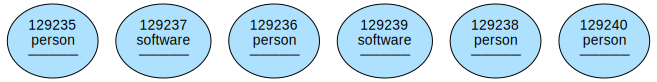

In [16]:
# clear the whole graph
g.V().drop().iterate()

marko = g.addV("person").next()
vadas = g.addV("person").next()
lop = g.addV("software").next()
josh = g.addV("person").next()
ripple = g.addV("software").next()
peter = g.addV("person").next()

GremlinDraw.show(g)

## property (Daten zu Knoten und Kanten modifizieren)

Mit der Funktion ```property(<Key>, <Value>)``` kann man Eigenschaften zu einem Element hinzufügen. Wird ein für dieses Element bereits verwendeter Key angegeben, so wird er mit dem neuen Wert überschrieben. Das Traversal bleibt beim modifizierten Knoten.

Da wir die Knoten des Modern-Graphen bereits erstellt haben, können wir nun die Records hinzufügen.

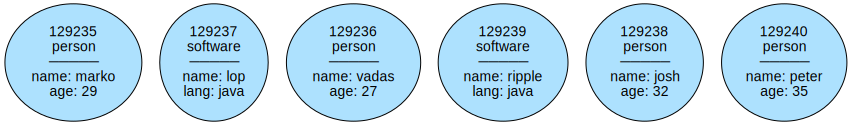

In [17]:
g.V(marko).property("name", "marko").property("age", 29).next()
g.V(vadas).property("name", "vadas").property("age", 27).next()
g.V(lop).property("name", "lop").property("lang", "java").next()
g.V(josh).property("name", "josh").property("age", 32).next()

# oder:
g.V(ripple).property("name", "ripple").property("lang", "java")\
    .V(peter).property("name", "peter").property("age", 35).next()

GremlinDraw.show(g)

## addE (Kanten hinzufügen)

Kanten sind in Gremlin gerichtet, wir müssen also Start- und Zielknoten sowie eine Richtung angeben.

```<Zielknoten>.addE(<Kantenlabel>).from_(<Startknoten>)```

Für den Startkonten ist eine Unterabfrage nötig. Da die Graph Traversal Source identisch zum übergeordneten Traversal sein muss, muss (und darf) diese nicht mit angegeben werden und das Traversal innerhalb der ```from_```-Funktion beginnt direkt mit dem Auswählen des Knotens. Es können auch mehrere Zielknoten angegeben werden.

<div class='alert alert-info'>Gremlin ist nativ in Java geschrieben. Wir nutzen hier eine GLV (Gremlin Language Variant) für Python. Da in Python manche Funktionsnamen standardmäßig belegt sind, werden an diese ein _ angehängt. Bsp: from_("xy")</div>

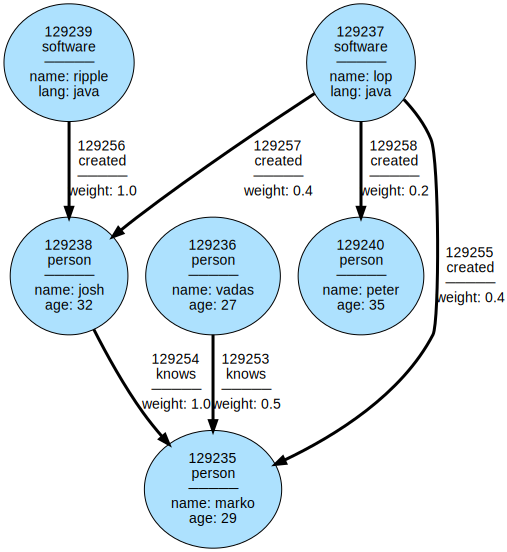

In [18]:
g.V(vadas).addE('knows').from_(V(marko)).property("weight", 0.5).iterate()
g.V(josh).addE('knows').from_(V(marko)).property("weight", 1.0).iterate()
g.V(lop).addE('created').from_(V(marko)).property("weight", 0.4).iterate()
g.V(ripple).addE('created').from_(V(josh)).property("weight", 1.0).iterate()

# oder:
g.V(lop).addE('created').from_(V(josh)).property("weight", 0.4)\
    .V(lop).addE('created').from_(V(peter)).property("weight", 0.2).iterate()

GremlinDraw.show(g)

## drop (Element löschen)

Knoten und Kanten können mit der Funktion ```drop()``` aus der Graphdatenbank gelöscht werden.

* **Beispiel:** Lösche die Knoten mit ID ```2```.

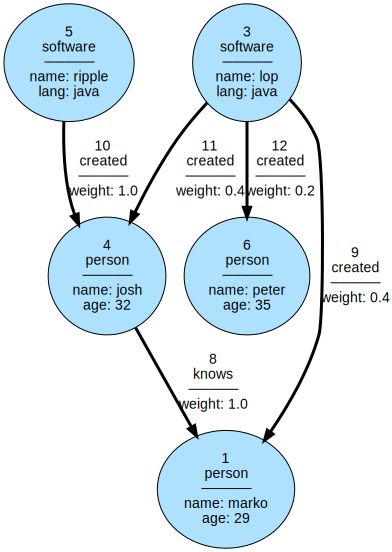

In [19]:
examples.load_by_name(g, "tinkerpop-modern")

g.V("2").fold().unfold().drop().iterate()

GremlinDraw.show(g)

Wird ein Knoten gelöscht, so werden auch alle Kanten zu und von diesem Knoten entfernt.
<div class='alert alert-info'>Beim Löschen von Kanten muss die ID des Knotens als String angegeben werden!</div>

* **Beispiel:** Lösche die Kante mit ID ```9```.

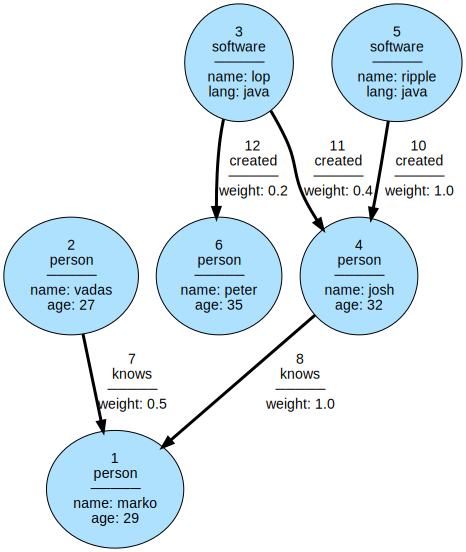

In [20]:
examples.load_by_name(g, "tinkerpop-modern")

g.E("9").drop().iterate()
GremlinDraw.show(g)

---
# Abfragen in Gremlin

Bei Graphdatenbanken läuft eine Abfrage anders ab als bei den bereits bekannten relationalen Datenbanken. Da hier die Daten nicht in Tabellen geordnet sind, werden in Graphabfragen zu Beginn einer Abfrage nicht einzelne Tabellen ausgewählt. Stattdessen werden entweder Knoten oder Kanten betrachtet. Man kann dann von diesen aus den Graph durchlaufen.

Für Abfragen sind die Schritte aus den Kategorien **map Steps**, **flatMap Steps**, **filter Steps** und **branch Steps** geeignet.

## filter Steps

![](https://i.imgur.com/tcoRBIq.png)

filter Steps filtern eine Menge von Elementen nach Kriterien. Die Traversierung wird somit zu einer Teilmenge der Elemente eingeschränkt.

### V, E

Wie bereits gesehen kann man als einfachste Gremlin-Abfrage alle Knoten oder Kanten eines Graphen ausgeben. IDs von Knoten und Kanten können als optionale Parameter angegeben werden.

```V([<Knoten-ID>[, <Knoten-ID>]])``` \
```E([<Kanten-ID>[, <Kanten-ID>]])```

* **Beispiel:** Gibt es einen Knoten mit der ID ```100```?

In [21]:
examples.load_by_name(g, "tinkerpop-modern")

g.V(100).hasNext()

False

### hasLabel
Möchte man statt nach einer ID nur bestimmte Labels finden, kann mit ```hasLabel``` gefiltert werden.

```hasLabel([<Label-Name>[, <Label-Name>]])```

* **Beispiel:** Gib alle Kanten aus, die das Label ```knows``` haben.

[e[7][1-knows->2], e[8][1-knows->4]]


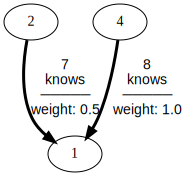

In [22]:
traversal = g.E().hasLabel("knows").toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

### has

Neben IDs und Labels besitzen die Elemente noch ihre Records, die den Attributen und Attributwerten in relationalen Datenbanken entsprechen. Um Knoten mit bestimmten Eigenschaften zu finden, wird die Funktion ```has``` verwendet.

```has(<Attribut> | {<Attribut>, <Wert>})```

* **Beispiel:** Gib alle Knoten aus, bei denen das Attribut ```name``` den Wert ```vadas``` hat.

[v[2]]


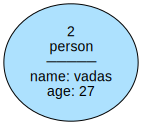

In [23]:
traversal = g.V().has("name", "vadas").toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

* **Beispiel:** Gib alle Knoten aus, die das Attribut ```lang``` besitzen.

[v[3], v[5]]


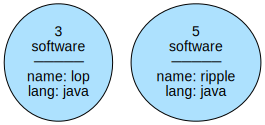

In [24]:
traversal = g.V().has("lang").toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

### and_

Die Funktion ```and_``` filtert die Elemente des aktuellen Traversals, die in _allen_ der in den Parametern angegebenen Traversals vorkommen.

```and(<Kriterium> [, <Kriterium])```

* **Beispiel:** Gib alle Knoten aus, die sowohl Records für ```lang``` als auch für ```age``` haben.

In [25]:
traversal = g.V().and_(
        has("lang"),
        has("age")).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[]


### or_

Analog zu ```and_``` filtert ```or_``` die Elemente des aktuellen Traversals, die in _mindestens einer_ der in den Parametern angegebenen Traversals vorkommen.

```or_(<Kriterium> [, <Kriterium])```

[v[3], v[5], v[6]]


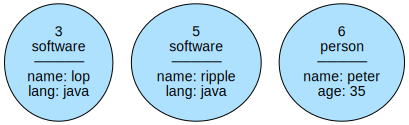

In [26]:
traversal = g.V().or_(
    has("age", 35),
    has("lang", "java")).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

### not_

```not_``` filtert die Elemente des Traversals, die nicht die Bedingung erfüllen.

```not_(<Kriterium>)```

[v[3], v[5]]


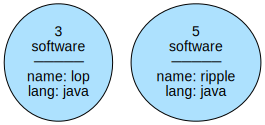

In [27]:
traversal = g.V().not_(has("age")).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

Bei dieser Funktion kann immer nur ein Parameter angegeben werden. Mehrere Bedingungen können aber z.B. aneinandergehängt werden.

[v[3]]


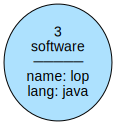

In [28]:
traversal = g.V().not_(has("age")).not_(has("name", "ripple")).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

### range_, limit, tail

Die Schritte ```range_```, ```limit``` und ```tail``` limitieren die Anzahl der Elemente, die im aktuellen Traversal enthalten sind.

```range_(<Start>, <Limit>)``` \
```limit(<Anzahl Elemente>)``` beschränkt das Traversal auf die ersten n gefundenen Elemente \
```tail(<Anzahl Elemente>)``` beschränkt das Traversal auf die letzten n gefundenen Elemente

* **Beispiel:** Gebe die zweite und dritte Person aus.

[v[2], v[4]]


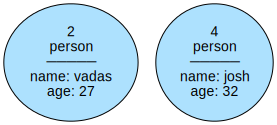

In [29]:
traversal = g.V().hasLabel("person").range_(1,3).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

* **Beispiel:** Gebe die ersten drei Personen aus.

[v[1], v[2], v[4]]


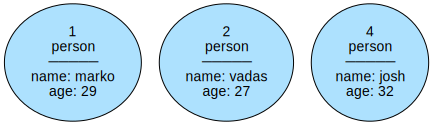

In [30]:
traversal = g.V().hasLabel("person").limit(3).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

* **Beispiel:** Gebe die letzten drei Personen aus.

[v[2], v[4], v[6]]


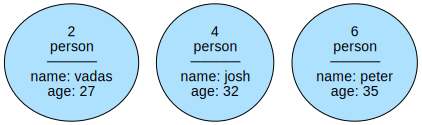

In [31]:
traversal = g.V().hasLabel("person").tail(3).toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

```limit(n)``` entspricht ```range_(0, n)```.

### dedup

Der Schritt ```dedup()``` verwirft alle Duplikate aus dem aktuellen Traversal.

* **Beispiel:** Gebe alle unterschiedlichen Labels von Knoten aus.

In [32]:
g.V().label().dedup().toList()

['person', 'software']

## flatMap Steps

![](https://i.imgur.com/vCGQalT.png)

Die flatMap Steps bewegen das Traversal auf benachbarte Elemente im Graph.

### in, out, both, inE, outE, bothE

Diese Funktionen können nur auf Knoten aufgerufen werden und geben eingehende oder/und ausgehende Knoten bzw. Kanten zurück. Werden Parameter angegeben, so wird nur anhand dieser Kantenlabels traversiert.

```<Knoten>.in_(<Kantenlabel> [, <Kantenlabel>]*)```, ```<Knoten>.inE(<Kantenlabel> [, <Kantenlabel>]*)```, \
```<Knoten>.out(<Kantenlabel> [, <Kantenlabel>]*)```, ```<Knoten>.outE(<Kantenlabel> [, <Kantenlabel>]*)```, \
```<Knoten>.both(<Kantenlabel> [, <Kantenlabel>]*)```, ```<Knoten>.bothE(<Kantenlabel> [, <Kantenlabel>]*)```



[v[3]]


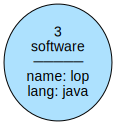

In [33]:
examples.load_by_name(g, "tinkerpop-modern")

traversal = g.V().has("name", "peter").out().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[e[12][6-created->3]]


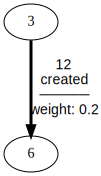

In [34]:
traversal = g.V().has("name", "peter").outE().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[v[4], v[6], v[1]]


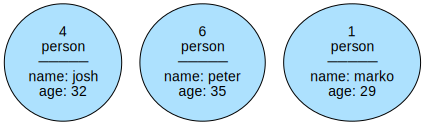

In [35]:
traversal = g.V().has("name", "lop").in_().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[e[11][4-created->3], e[12][6-created->3], e[9][1-created->3]]


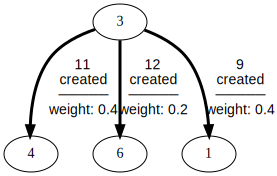

In [36]:
traversal = g.V().has("name", "lop").inE().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[v[3], v[5]]


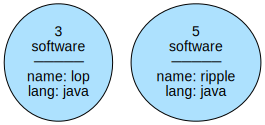

In [37]:
traversal = g.V(4).both("created").toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[e[11][4-created->3], e[10][4-created->5], e[8][1-knows->4]]


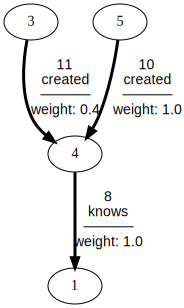

In [38]:
traversal = g.V(4).bothE().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)


### inV, outV, bothV

Diese Funktionen können nur auf Kanten aufgerufen werden und geben ausgehende bzw. eingehende Knoten aus.

```<Kante>.outV()```, \
```<Kante>.inV()```, \
```<Kante>.bothV()```

[v[4]]


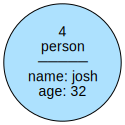

In [39]:
traversal = g.E("11").outV().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[v[3]]


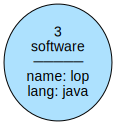

In [40]:
traversal = g.E("11").inV().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

[v[4], v[3]]


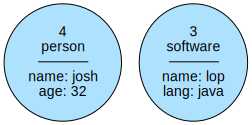

In [41]:
traversal = g.E("11").bothV().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

### otherV

Diese Funktion bewegt die Traversierung zu dem Knoten, von dem sie nicht kommt. Sie kann nur auf einer Kante aufgerufen werden.

```<Kante>.otherV()```

[v[3], v[3], v[3], v[2], v[4], v[5]]


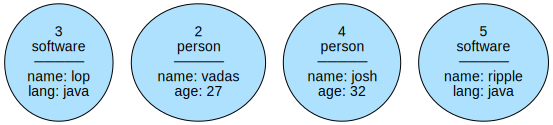

In [42]:
traversal = g.V().hasLabel('person').outE().otherV().toList()

print(traversal)
GremlinDraw.show_graph_traversal(g, traversal)

## map Steps

![](https://i.imgur.com/zngQBc8.png)

Die map Steps bilden die Elemente des aktuellen Traversals auf Informationen als Traversal ab. Oft werden ein oder mehrere map Steps als letztes vor einem Terminal Step ausgeführt.

### identity

Der Schritt ```identity()``` bildet alle Elemente des Traversals auf sich selbst ab. Er ist insbesondere in verschachtelten Traversals hilfreich, da die inneren Traversals in Gremlin-Python in manchen Fällen einen Fehler erzeugen.

### id_, label, properties, values

Wie wir bereits gesehen haben, werden standardmäßig Repräsentationen von kompletten Elementen ausgegeben. Man kann aber auch die Elemente auf ihre einzelnen Eigenschaften projizieren.
Es können auch mit der Funktion ```values``` alle oder einzelne Werte ausgeben.

```values([<Key>[, <Key>]])```

* **Beispiel:** Gib die Informationen zu allen Knoten mit der Eigenschaft ```age``` aus.

In [43]:
examples.load_by_name(g, "tinkerpop-modern")

g.V().has("age").id_().toList()

[1, 2, 4, 6]

In [44]:
g.V().has("age").label().toList()

['person', 'person', 'person', 'person']

In [45]:
g.V().has("age").properties().toList()

[vp[name->marko],
 vp[age->29],
 vp[name->vadas],
 vp[age->27],
 vp[name->josh],
 vp[age->32],
 vp[name->peter],
 vp[age->35]]

In [46]:
g.V().has("age").values().toList()

['marko', 29, 'vadas', 27, 'josh', 32, 'peter', 35]

In [47]:
g.V().has("age").values("name").toList()

['marko', 'vadas', 'josh', 'peter']

### elementMap, valueMap

Die Funktion ```valueMap()``` gibt statt eine Liste mit Objekten zurück, die die Records beinhalten.

In [48]:
g.V().has("age").valueMap().toList()

[{'name': ['marko'], 'age': [29]},
 {'name': ['vadas'], 'age': [27]},
 {'name': ['josh'], 'age': [32]},
 {'name': ['peter'], 'age': [35]}]

Zusätzlich dazu gibt die Funktion ```elementMap()``` auch noch die zugehörigen IDs und Labels aus.

In [49]:
g.V().has("age").elementMap().toList()

[{<T.id: 1>: 1, <T.label: 4>: 'person', 'name': 'marko', 'age': 29},
 {<T.id: 1>: 2, <T.label: 4>: 'person', 'name': 'vadas', 'age': 27},
 {<T.id: 1>: 4, <T.label: 4>: 'person', 'name': 'josh', 'age': 32},
 {<T.id: 1>: 6, <T.label: 4>: 'person', 'name': 'peter', 'age': 35}]

### count

Diese Funktion bildet auf die Anzahl der Ergebnisse ab.

* **Beispiel:** Wie viele ausgehende Kanten hat der Knoten mit ID ```1```?

In [50]:
g.V(1).outE().count().next()

3

### min_, max_, mean, sum_

Diese Funktionen benötigen als Eingabe ein Traversal, welches auf vergleichbare Objekte abbildet. Bei ```mean``` und ```sum_``` müssen es Zahlen sein, bei ```min_``` und ```max_``` hingegen ist z.B. auch ein String-Vergleich möglich.

* **Beispiel:** Welches ist der minimale Wert der Kanteneigenschaft ```weight```, mit dem ein Programm kreiert wurde?

In [51]:
g.E().hasLabel("created").values("weight").min_().next()

0.2

* **Beispiel:** Welche Person hat alphabetisch sortiert den letzten Namen?

In [52]:
g.V().hasLabel("person").values("name").max_().next()

'vadas'

* **Beispiel:** Was ist das Durchschnittsalter der Personen?

In [53]:
g.V().hasLabel("person").values("age").mean().next()

30.75

### group, by

Mit den Funktionen ```group()``` und ```by(<Kriterium>)``` kann man Elemente gruppieren. Wird ```group``` alleine angegeben, so wird jedes Element einzeln gruppiert.

In [54]:
g.V(1).outE().group().toList()

[{e[8][1-knows->4]: [e[8][1-knows->4]],
  e[9][1-created->3]: [e[9][1-created->3]],
  e[7][1-knows->2]: [e[7][1-knows->2]]}]

* **Beispiel:** Gib die ausgehenden Kanten des Knotens mit ID ```1``` gruppiert nach Label aus.

In [55]:
g.V(1).outE().group().by(label).toList()

[{'created': [e[9][1-created->3]],
  'knows': [e[7][1-knows->2], e[8][1-knows->4]]}]

* **Beispiel:** Gib die Knoten des Graphen gruppiert nach Anzahl ihrer ausgehenden Kanten aus.

In [56]:
g.V().group().by(outE().count()).toList()

[{0: [v[2], v[3], v[5]], 1: [v[6]], 2: [v[4]], 3: [v[1]]}]

* **Beispiel:** Gib die Anzahl Knoten pro Anzahl ausgehender Kanten aus.

In [57]:
g.V().group().by(outE().count()).by(count()).toList()

[{0: 3, 1: 1, 2: 1, 3: 1}]

### fold, unfold?

Mit ```fold()``` (und ```unfold()``` als Umkehrung der Operation) kann man die Ergebnisse zu einer gemeinsamen Liste aggregieren. Im Gegensatz zum Terminal Step ```toList()``` wird das Traversal aber nicht beendet.

In [58]:
g.V(1).out('knows').values('name').next()

'vadas'

In [59]:
g.V(1).out('knows').values('name').fold().next()

['vadas', 'josh']

In [60]:
g.V(1).out('knows').values('name').fold().fold().fold().unfold().next()

[['vadas', 'josh']]

### order, by
Der ```order()```-Step ist nützlich zum Sortieren von Elementen. Vor diesem Step sind die Elemente nach dem vorangegangenen Traversal sortiert. Mit dem Step Modulator ```by(<Kriterium>)``` können Kriterien angegeben werden, nach denen sortiert werden soll. Ohne ```by``` werden die Elemente aufsteigend sortiert.

* **Beispiel:** Gebe die Werte zum Key ```name``` aller Knoten in alphabetischer Reihenfolge aus.

In [61]:
g.V().values('name').order().toList()
# äquivalent zu: g.V().values('name').order().by(asc).toList()

['josh', 'lop', 'marko', 'peter', 'ripple', 'vadas']

* **Beispiel:** Gebe die Werte zum Key ```name``` aller Knoten in umgekehrter alphabetischer Reihenfolge aus.

In [62]:
g.V().values('name').order().by(desc).toList()

['vadas', 'ripple', 'peter', 'marko', 'lop', 'josh']

* **Beispiel:** Gebe die Namen aller Personen an, absteigend nach ihrem Alter.

In [63]:
g.V().hasLabel('person').order().by('age', desc).values('name').toList()

['peter', 'josh', 'marko', 'vadas']

### path
Der ```path()```-Step bildet die Elemente des aktuellen Traversals auf ihre Pfade ab, also ihren Verlauf während den bis dahin ausgeführten Traversals.

In [64]:
g.V().out().out().values('name').path().toList()

[path[v[1], v[4], v[3], lop], path[v[1], v[4], v[5], ripple]]

### select, as_

Mit dem ```select()```-Step wird das Traversal auf eine Auswahl von Ergebnissen abgebildet, die zuvor mit der ```as_(<Name>)```-Funktion spezifiziert wurden. Analog zu ```by``` ist ```as_``` ein Step Modulator, d.h. die Funktion kann alleine verwendet werden, hat dann aber keine Auswirkungen auf das Traversal:

* **Beispiel:** Gib für alle Knoten mit einem Nachfolger die ausgehenden Kanten dieses Nachfolgers aus.

In [65]:
g.V().as_('a').out().as_('b').outE().as_('c').toList()
# äquivalent zu: g.V().out().outE().toList()

[e[11][4-created->3], e[10][4-created->5]]

* **Beispiel:** Wähle alle Pfade aus, die eine ausgehende Kante aus einem Nachfolger eines Knotens beinhalten. Gib für jeden Pfad den Nachfolger und die zugehörige ausgehende Kante an.

In [66]:
g.V().as_('Knoten').out().as_('Nachfolger').outE().as_('Kante').select("Nachfolger", "Kante").toList()

[{'Nachfolger': v[4], 'Kante': e[11][4-created->3]},
 {'Nachfolger': v[4], 'Kante': e[10][4-created->5]}]

## branch Steps

![](https://i.imgur.com/3crbN1C.png)

Branch Steps teilen den Traverser auf. Sie sind insbesondere dann nützlich, wenn mit verschiedenen Elementen unterschiedlich weiter vorgegangen werden soll.

### choose, option
Mit ```choose``` lassen sich Verzweigungen darstellen. Sowohl binäre Verzweigungen (if/else) als auch Verzweigungen mit beliebig vielen Bedingungen sind möglich. Die ```option```-Funktion ist hier (genau wie ```as_```) ein Step Modulator, hat also nur Wirkung im Zusammenhang mit dem ihm zugehörigen Step selbst.

```choose(<Bedingung>, <if-Traversal>, <else-Traversal>)```\
```choose(<Wert>).option(<Bedingung 1>, <Handle-Traversal 1>).option(<Bedingung 2>, <Handle-Traversal 2>) ...```

* **Beispiel:** s. union

### union
Mit ```union(<Traversal 1>, <Traversal 2>, ...)``` kann man mehrere Traversals zusammenfassen. Das resultierende Traversal beinhaltet die Elemente aller Traversals.

* **Beispiel:** Gib für jeden Person-Knoten basierend auf dem Alter der Person benachbarte Knoten aus: für Personen unter 30 Jahren alle ausgehenden Knoten, für alle anderen Personen alle eingehenden Knoten.

In [67]:
examples.load_by_name(g, "tinkerpop-modern")

g.V().hasLabel("person").as_("Person").choose(has("age", lt(30)), out().as_("Nachfolger"), in_().as_("Vorgänger")).\
    values("name").as_("Name").union(select("Person", "Nachfolger", "Name"), select("Person", "Vorgänger", "Name")).toList()

[{'Person': v[1], 'Nachfolger': v[3], 'Name': 'lop'},
 {'Person': v[1], 'Nachfolger': v[2], 'Name': 'vadas'},
 {'Person': v[1], 'Nachfolger': v[4], 'Name': 'josh'},
 {'Person': v[4], 'Vorgänger': v[1], 'Name': 'marko'}]

In [68]:
# äquivaltent zu:
g.V().hasLabel("person").as_("Person").choose(has("age").values("age")).option(lt(30), out().as_("Nachfolger")).option(gte(30), in_().as_("Vorgänger")).\
    values("name").as_("Name").union(select("Person", "Nachfolger", "Name"), select("Person", "Vorgänger", "Name")).toList()

[{'Person': v[1], 'Nachfolger': v[3], 'Name': 'lop'},
 {'Person': v[1], 'Nachfolger': v[2], 'Name': 'vadas'},
 {'Person': v[1], 'Nachfolger': v[4], 'Name': 'josh'},
 {'Person': v[4], 'Vorgänger': v[1], 'Name': 'marko'}]

<div class='alert alert-info'>Wir haben die Funktion lt() angewendet, mit der hier überprüft wird, ob das Alter kleiner als ein spezifischer Wert ist. Analog können auch lte(), eq(), gte() und gt() verwendet werden.</div>

### repeat
Die ```repeat```-Funktion wiederholt ein Traversal, bis eine Anzahl Wiederholungen erreicht ist oder ein Kriterium erfüllt ist.

```repeat(<Traversal>).times(<Wiederholungen>)``` \
```until(<Bedingung>).repeat(<Traversal>)```

* **Beispiel:** Ausgehend vom Knoten mit ID ```3```, navigiere das Traversal zweimal zu benachbarten Knoten. Gib alle Pfade mit den Namen der Knoten aus.

In [69]:
g.V(3).repeat(both()).times(2).path().by("name").toList()

[path[lop, josh, lop],
 path[lop, josh, ripple],
 path[lop, josh, marko],
 path[lop, peter, lop],
 path[lop, marko, lop],
 path[lop, marko, vadas],
 path[lop, marko, josh]]

* **Beispiel:** Ausgehend von einem beliebigen Knoten, navigiere das Traversal solange zu benachbarten Knoten, bis ein Knoten mit dem Namen ```lop``` enthalten ist.

In [70]:
g.V().until(has("name", "lop")).repeat(out()).path().by("name").toList()

[path[marko, lop],
 path[marko, josh, lop],
 path[lop],
 path[josh, lop],
 path[peter, lop]]

# Größere Graphen

Nachdem wir auf dem Modern-Graphen die wesentlichen Traversal-Steps kennengelernt haben, gibt es in diesem Kapitel ein paar Anfragen für größere Graphdatenbanken.

## Air-Routes

In [71]:
examples.load_by_name(g, "air-routes-latest")
g.V().count().next()

3749

In [72]:
g.E().count().next()

57645

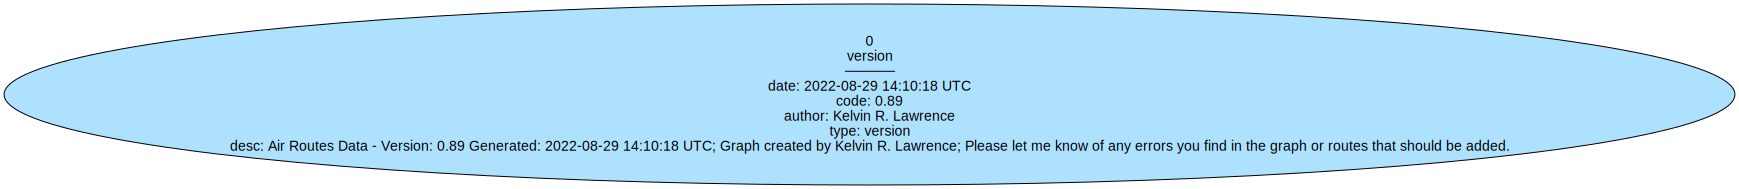

In [73]:
# show a single node
GremlinDraw.show(g,v_limit=1,e_limit=0)

In [74]:
# Kleineres Beispiel laden
examples.load_by_name(g, "air-routes-small")
g.E().count().next()

1326

In [75]:
# Name der Städte, die von Atlanta mit einem Direktflug von mehr als 1000 mi erreicht werden können
g.V().has("city", "Atlanta").outE().has("dist", gt(1000)).inV().values("city").toList()

['Seattle',
 'San Francisco',
 'San Jose',
 'San Diego',
 'Long Beach',
 'Santa Ana',
 'Salt Lake City',
 'Las Vegas',
 'Denver',
 'Los Angeles',
 'Honolulu',
 'El Paso',
 'San Juan',
 'Phoenix',
 'Oakland',
 'Tucson']

In [76]:
# Alle Daten zu Städten in Texas, die von Anchorage aus mit einem Direktflug erreichbar sind und mehr als 5 Runways haben
g.V().has("city", "Anchorage").out().has("region","US-TX").has("runways", gt(5)).elementMap().toList()

[{<T.id: 1>: 8,
  <T.label: 4>: 'airport',
  'country': 'US',
  'code': 'DFW',
  'longest': 13401,
  'city': 'Dallas',
  'elev': 607,
  'icao': 'KDFW',
  'lon': -97.0380020141602,
  'type': 'airport',
  'region': 'US-TX',
  'runways': 7,
  'lat': 32.896800994873,
  'desc': 'Dallas/Fort Worth International Airport'}]

In [77]:
# Alle Flughäfen nördlich von Detroit
latAng = g.V().has("city", "Detroit").values("lat").next()
print(latAng)
g.V().has("lat", gt(latAng)).values("city", "lat").toList()

42.2123985290527


['Anchorage',
 61.1744003295898,
 'Boston',
 42.36429977,
 'Minneapolis',
 44.8819999695,
 'Seattle',
 47.4490013122559]

In [78]:
# Alle Flughäfen, von denen aus man nach Palma De Mallorca fliegen kann, gruppiert nach Land
g.V().has("city", "Palma De Mallorca").in_().group().by("country").toList()

[{}]

In [79]:
# Name der Städte, deren Flughafen höher als 1000 ft ist.
g.V().has("elev").has("elev", gt(1000)).values("city").toList()

['Atlanta', 'Phoenix', 'Las Vegas', 'Denver', 'El Paso', 'Tucson', 'Santa Fe']